In [1]:
!pip install opencv-python

In [2]:
!pip install mediapipe

In [12]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands #손동작 인식 모듈 불러오기
 
cap = cv2.VideoCapture(0) #OpenCV로 웹캠을 읽어 입력데이터 소스로 지정
 
with mp_hands.Hands( #손가락 인식모듈의 작동 option 지정
    max_num_hands=1, #인식할 손모양의 갯수, default = 2
    min_detection_confidence=0.5, #탐지가 성공적인 것으로 간주되는 최소 신뢰도 값. [0.0~1.0], default=0.5
    min_tracking_confidence=0.5) as hands:  #손 랜드마크가 성공적으로 추적된 것으로 간주되는 최소 신뢰도 값. [0.0~1.0], defualt=0.5, 이 값을 높이면 시간이 더 소요되지만 더 정확한 작동이 보장됨
 
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB) #OpenC 영상은 BGR 영상인데 MediaPipe에서는 RGB형식을 사용하므로 영상형식 변환
 
        results = hands.process(image) #MediaPipe의 hands 모듈을 이용하여 손동작 인식. 이 한줄로 손동작 인식 모듈 작동되고 결과 값 result에 저장
 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  #MediaPipe용 RGB형식으로 변환했던 것을 OpenCV 영상처리릉 위해 다시 BGR형식으로 되돌림
 
        if results.multi_hand_landmarks: #result값이 정상인 경우에만 후속 작업 처리
            for hand_landmarks in results.multi_hand_landmarks: #result로 반환된 landmark 데이터 사용
                finger1 = int(hand_landmarks.landmark[4].x * 100 ) #하단 설명 참고
                finger2 = int(hand_landmarks.landmark[8].x * 100 ) #하단 설명 참고
                dist = abs(finger1 - finger2) #두 손가락 끝의 x좌표값 차이의 절대값을 구해 두 손가락 끝이 벌어진 정도 계산
                cv2.putText( # 창에 구한 엄지와 검지 x좌표의 백분율 값과 dist값을 Text로 띄우기
                    image, text='f1=%d f2=%d dist=%d ' % (finger1,finger2,dist), org=(10, 30),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                    color=255, thickness=3)
 
                mp_drawing.draw_landmarks( #MediaPipe 내장 유틸리티 기능을 이용하여 구해진 손가락 모양을 서로 연결한 그림을 그려줌
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        cv2.imshow('image', image)
        if cv2.waitKey(1) == ord('q'):
            break
 
cap.release()
cv2.destroyAllWindows()

인식된 손가락 모양은 다음과 같은 index값을 가지는 배열로 제공됨

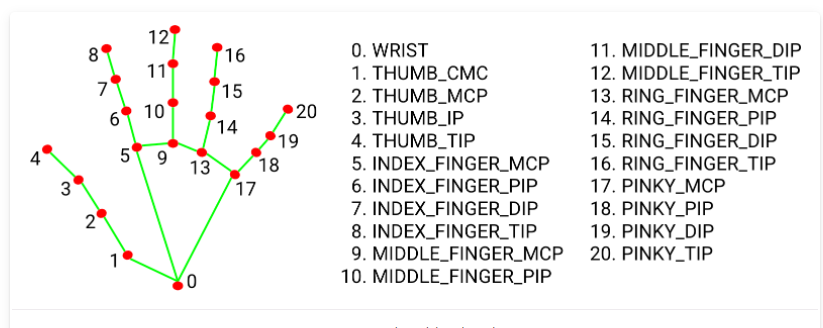

엄지손가락 끝은 landmark[4]에, 검지 손가락 끝은 landmark[8]에 좌표값이 반환되는데, 좌표값은 image상의 x,y위치값을 0.0~1.0 사이의 값으로 표시함 즉 image 좌측 최상단은 x=0.0 y=0.0  우측최하단은 x=1.0, y=1.0이 된다. 따라서int(hand_landmarks.landmark[4].x * 100)은 엄지손가락 끝의 x좌표를 100분율로 표시한 것이 됨 

In [10]:
### 가위바위보 알아맞추기 
import math
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands #손동작 인식 모듈 불러오기

cap = cv2.VideoCapture(1) 
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)


def get_xy_by_index(index): 
    return [int(hand_landmarks.landmark[index].x * width ),
            int(hand_landmarks.landmark[index].y * height )]

def get_center_of_palm():
    target_joints = [get_xy_by_index(0), get_xy_by_index(1), get_xy_by_index(2), 
                    get_xy_by_index(5), get_xy_by_index(9), get_xy_by_index(13), get_xy_by_index(17)]

    xs, ys = 0, 0
    for joints in target_joints: 
        xs += joints[0]
        ys += joints[1]
    
    return (int(xs/len(target_joints)), int(ys/len(target_joints)))

def get_distance_btw_2xys(point1, point2): 
    x1, y1 = point1
    x2, y2 = point2
    
    return math.sqrt(math.pow((x1-x2), 2) + math.pow((y1-y2), 2))

def check_rock_paper_scissors(palm, radius, thumb, index, middle, ring, pinky):
    d_thumb = get_distance_btw_2xys(palm, thumb)
    d_index = get_distance_btw_2xys(palm, index)
    d_middle = get_distance_btw_2xys(palm, middle)
    d_ring = get_distance_btw_2xys(palm, ring)
    d_pinky = get_distance_btw_2xys(palm, pinky)
    
    if radius < d_thumb and radius < d_index and radius < d_middle and radius < d_ring and radius < d_pinky :
        return 'paper'
    elif radius > d_thumb and radius > d_index and radius > d_middle and radius > d_ring and radius > d_pinky :
        return 'rock'
    elif radius < d_thumb and radius < d_index and radius > d_middle and radius > d_ring and radius > d_pinky :
        return 'scissors'
    return 'Dont know'
    

with mp_hands.Hands( 
    max_num_hands=1, 
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5) as hands:  
 
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB) 
 
        results = hands.process(image) 
 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  
 
        if results.multi_hand_landmarks: 
            for hand_landmarks in results.multi_hand_landmarks: 
                # 각 손가락 끝 위치를 구하기 
                thumb = get_xy_by_index(4)
                index = get_xy_by_index(8)
                middle = get_xy_by_index(12)
                ring = get_xy_by_index(16)
                pinky = get_xy_by_index(20)

                # 손바닥 중앙 위치 & 손바닥 반지름 구하기 
                c_palm = get_center_of_palm()
                radius = get_distance_btw_2xys(get_xy_by_index(0), get_xy_by_index(9)) / 2 

                
                # 손가락과 손바닥 위치 관계로 가위, 바위, 보를 예측
                RSP = check_rock_paper_scissors(c_palm, radius, thumb, index, middle, ring, pinky)

                cv2.putText( 
                    image, text=RSP, 
                    org=(10, 30),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                    color=255, thickness=3)
                
                # 손바닥 중앙과 반지름으로 원 그리기 
                cv2.circle(image, c_palm, int(radius), (0, 255, 255), 2)
                cv2.line(image, c_palm, c_palm, (0, 255, 255), 4)
                
                mp_drawing.draw_landmarks( 
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
 
        cv2.imshow('image', image)
        if cv2.waitKey(1) == ord('q'):
            break
 
cap.release()
cv2.destroyAllWindows()